In [3]:
from dotenv import load_dotenv
load_dotenv("../.env", override=True)

True

In [4]:
from langchain.chat_models import init_chat_model
llm = init_chat_model("openai:gpt-4.1", temperature=0)

## Running the model

The `init_chat_model` interface provides [standardized](https://python.langchain.com/docs/concepts/runnables/) methods for using chat models, which include:
- `invoke()`: A single input is transformed into an output.
- `stream()`: Outputs are [streamed](https://python.langchain.com/docs/concepts/streaming/#stream-and-astream) as they are produced. 

In [5]:
result = llm.invoke("What is an agent?")

In [6]:
type(result)

langchain_core.messages.ai.AIMessage

In [7]:
from rich.markdown import Markdown
Markdown(result.content)

The term "agent" can have different meanings depending on the context. Here are some common definitions:           

                                               1. General Definition                                               

An agent is someone or something that acts on behalf of another or has the power to act.                           

                              2. In Artificial Intelligence (AI) and Computer Science                              

An agent is an entity that perceives its environment through sensors and acts upon that environment through        
actuators to achieve specific goals. For example:                                                                  

 • A robot vacuum cleaner is an agent: it senses dirt and obstacles and moves to clean.                            
 • A software bot that responds to emails is an agent.                                                             

                                              3. In Business and Law                                               

An agent is a person authorized to act on behalf of another (the principal) in business transactions. For example: 

 • A real estate agent sells property for clients.                                                                 
 • A sports agent negotiates contracts for athletes.                                                               

                                            4. In Chemistry and Biology                                            

An agent can refer to a substance that brings about a chemical or biological effect. For example:                  

 • A cleaning agent removes stains.                                                                                
 • An infectious agent causes disease.                                                                             

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Summary:                                                                                                           
An agent is generally any person, thing, or software that acts, does something, or causes something to happen,     
often on behalf of someone or something else. The specific meaning depends on the field or context.

In [8]:
from langchain.tools import tool

@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}' and content: {content}"

In [9]:
type(write_email)

langchain_core.tools.structured.StructuredTool

In [10]:
write_email.args

{'to': {'title': 'To', 'type': 'string'},
 'subject': {'title': 'Subject', 'type': 'string'},
 'content': {'title': 'Content', 'type': 'string'}}

In [11]:
Markdown(write_email.description)

Write and send an email.

In [12]:
# Connect tools to a chat model
model_with_tools = llm.bind_tools([write_email], tool_choice="any", parallel_tool_calls=False)

# The model will now be able to call tools
output = model_with_tools.invoke("Draft a response to my boss (boss@company.ai) about tomorrow's meeting")

In [13]:
type(output)

langchain_core.messages.ai.AIMessage

In [14]:
output

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_gyJQ0cpfIry0fImu5NtUlSGm', 'function': {'arguments': '{"to":"boss@company.ai","subject":"Re: Tomorrow\'s Meeting","content":"Hello,\\n\\nThank you for the reminder about tomorrow\'s meeting. I confirm my attendance and will be prepared with the necessary updates and materials.\\n\\nPlease let me know if there is anything specific you would like me to focus on or bring to the discussion.\\n\\nBest regards,\\n\\n[Your Name]"}', 'name': 'write_email'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 92, 'prompt_tokens': 67, 'total_tokens': 159, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_3502f4eb73', 'id': 'chatcmpl-CJkHVTfLudsIFEwUQgbi4TFuLLAJ4', 'servi

In [15]:
# Extract tool calls and execute them
args = output.tool_calls[0]['args']
args

{'to': 'boss@company.ai',
 'subject': "Re: Tomorrow's Meeting",
 'content': "Hello,\n\nThank you for the reminder about tomorrow's meeting. I confirm my attendance and will be prepared with the necessary updates and materials.\n\nPlease let me know if there is anything specific you would like me to focus on or bring to the discussion.\n\nBest regards,\n\n[Your Name]"}

In [16]:
# Call the tool
result = write_email.invoke(args)
Markdown(result)

Email sent to boss@company.ai with subject 'Re: Tomorrow's Meeting' and content: Hello,                            

Thank you for the reminder about tomorrow's meeting. I confirm my attendance and will be prepared with the         
necessary updates and materials.                                                                                   

Please let me know if there is anything specific you would like me to focus on or bring to the discussion.         

Best regards,                                                                                                      

[Your Name]

## Workflows

In [72]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

class StateSchema(TypedDict):
    request: str
    email: str

workflow = StateGraph(StateSchema)

In [73]:
def write_email_node(state: StateSchema) -> StateSchema:
    # Imperative code that processes the request
    output = model_with_tools.invoke(state["request"])
    args = output.tool_calls[0]['args']
    email = write_email.invoke(args)
    return {"email": email}

In [74]:
workflow = StateGraph(StateSchema)
workflow.add_node("write_email_node", write_email_node)
workflow.add_edge(START, "write_email_node")
workflow.add_edge("write_email_node", END)

app = workflow.compile()

In [75]:
app.invoke({"request": "Draft a response to my boss (boss@company.ai) about tomorrow's meeting"})

{'request': "Draft a response to my boss (boss@company.ai) about tomorrow's meeting",
 'email': "Email sent to boss@company.ai with subject 'Re: Tomorrow's Meeting' and content: Hello,\n\nThank you for the reminder about tomorrow's meeting. I confirm my attendance and will be prepared with the necessary updates and materials.\n\nPlease let me know if there is anything specific you would like me to focus on or bring to the discussion.\n\nBest regards,\n\n[Your Name]"}

Routing between nodes can be done [conditionally](https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges) using a simple function. 

The return value of this function is used as the name of the node (or list of nodes) to send the state to next. 

You can optionally provide a dictionary that maps the `should_continue` output to the name of the next node.

In [76]:
import sys
import os
# Add the src directory to Python path so we can import email_assistant
sys.path.append(os.path.join('..', 'src'))

from typing import Literal
from langgraph.graph import MessagesState

# Try to import show_graph, if it fails, provide a simple alternative
try:
    from email_assistant.utils import show_graph
except ImportError:
    # Simple alternative if the import fails
    def show_graph(graph):
        print("Graph structure:")
        print(f"Nodes: {list(graph.nodes.keys())}")
        print("Note: Install graphviz and enable show_graph for full visualization")

def call_llm(state: MessagesState) -> MessagesState:
    """Run LLM"""

    output = model_with_tools.invoke(state["messages"])
    return {"messages": [output]}

def run_tool(state: MessagesState):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        observation = write_email.invoke(tool_call["args"])
        result.append({"role": "tool", "content": observation, "tool_call_id": tool_call["id"]})
    return {"messages": result}

def should_continue(state: MessagesState) -> Literal["run_tool", "__end__"]:
    """Route to tool handler, or end if Done tool called"""
    
    # Get the last message
    messages = state["messages"]
    last_message = messages[-1]
    
    # If the last message is a tool call, check if it's a Done tool call
    if last_message.tool_calls:
        return "run_tool"
    # Otherwise, we stop (reply to the user)
    return END

workflow = StateGraph(MessagesState)
workflow.add_node("call_llm", call_llm)
workflow.add_node("run_tool", run_tool)
workflow.add_edge(START, "call_llm")
workflow.add_conditional_edges("call_llm", should_continue, {"run_tool": "run_tool", END: END})
workflow.add_edge("run_tool", END)

# Run the workflow
app = workflow.compile()

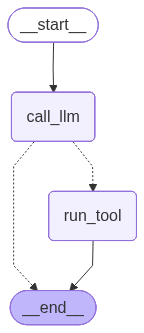

In [77]:
from IPython.display import Image,display
display(Image(app.get_graph().draw_mermaid_png()))

In [78]:
show_graph(app)

Graph structure:
Nodes: ['__start__', 'call_llm', 'run_tool']
Note: Install graphviz and enable show_graph for full visualization


In [79]:
result = app.invoke({"messages": [{"role": "user", "content": "Draft a response to my boss (boss@company.ai) confirming that I want to attend Interrupt!"}]})
for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

Draft a response to my boss (boss@company.ai) confirming that I want to attend Interrupt!
================================== Ai Message ==================================
Tool Calls:
  write_email (call_aBBbRvcwqyUeq8Ru2IHXWLgQ)
 Call ID: call_aBBbRvcwqyUeq8Ru2IHXWLgQ
  Args:
    to: boss@company.ai
    subject: Confirmation: Attendance at Interrupt!
    content: Hi,

Thank you for letting me know about Interrupt! I would like to confirm that I am interested in attending the event.

Please let me know if there are any next steps or additional details I should be aware of.

Best regards,

[Your Name]
================================= Tool Message =================================

Email sent to boss@company.ai with subject 'Confirmation: Attendance at Interrupt!' and content: Hi,

Thank you for letting me know about Interrupt! I would like to confirm that I am interested in attending the event.

Please let

With these low level components, you can build many many different workflows and agents. See [this tutorial](https://langchain-ai.github.io/langgraph/tutorials/workflows/)!

Because agents are such a common pattern, [LangGraph](https://langchain-ai.github.io/langgraph/tutorials/workflows/#pre-built) has [a pre-built agent](https://langchain-ai.github.io/langgraph/agents/overview/?ref=blog.langchain.dev#what-is-an-agent) abstraction.

With LangGraph's [pre-built method](https://langchain-ai.github.io/langgraph/tutorials/workflows/#pre-built), we just pass in the LLM, tools, and prompt. 

In [80]:
from langgraph.prebuilt import create_react_agent

agent = create_react_agent(
    model=llm,
    tools=[write_email],
    prompt="Respond to the user's request using the tools provided."  
)

# Run the agent
result = agent.invoke(
    {"messages": [{"role": "user", "content": "Draft a response to my boss (boss@company.ai) confirming that I want to attend Interrupt!"}]}
)

for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

Draft a response to my boss (boss@company.ai) confirming that I want to attend Interrupt!
================================== Ai Message ==================================
Tool Calls:
  write_email (call_K71ptU1alwIWMvNQa0IfkXdn)
 Call ID: call_K71ptU1alwIWMvNQa0IfkXdn
  Args:
    to: boss@company.ai
    subject: Confirmation: Attendance at Interrupt!
    content: Hi,

Thank you for the opportunity. I am confirming that I would like to attend Interrupt! Please let me know if there are any next steps or additional information needed from my side.

Best regards,

[Your Name]
================================= Tool Message =================================
Name: write_email

Email sent to boss@company.ai with subject 'Confirmation: Attendance at Interrupt!' and content: Hi,

Thank you for the opportunity. I am confirming that I would like to attend Interrupt! Please let me know if there are any next steps or a

### Persistence

#### Threads

It can be very useful to allow agents to pause during long running tasks.

LangGraph has a built-in persistence layer, implemented through checkpointers, to enable this. 

When you compile graph with a checkpointer, the checkpointer saves a [checkpoint](https://langchain-ai.github.io/langgraph/concepts/persistence/#checkpoints) of the graph state at every step. 

Checkpoints are saved to a thread, which can be accessed after graph execution completes.

![checkpointer](img/checkpoints.png)

We compile the graph with a [checkpointer](https://langchain-ai.github.io/langgraph/concepts/persistence/#checkpointer-libraries).


In [81]:
from langgraph.checkpoint.memory import InMemorySaver

agent = create_react_agent(
    model=llm,
    tools=[write_email],
    prompt="Respond to the user's request using the tools provided.",
    checkpointer=InMemorySaver()
)

config = {"configurable": {"thread_id": "1"}}
result = agent.invoke({"messages": [{"role": "user", "content": "What are some good practices for writing emails?"}]}, config)
                    

In [82]:
# Get the latest state snapshot
config = {"configurable": {"thread_id": "1"}}
state = agent.get_state(config)
for message in state.values['messages']:
    message.pretty_print()

================================ Human Message =================================

What are some good practices for writing emails?
================================== Ai Message ==================================

Here are some good practices for writing effective emails:

1. **Use a Clear Subject Line:** Make your subject concise and informative so the recipient knows what to expect.

2. **Greet Appropriately:** Start with a polite greeting, such as “Hello [Name],” or “Dear [Name],” depending on the formality.

3. **Be Concise and to the Point:** State your purpose early and keep your message focused. Avoid unnecessary details.

4. **Use Proper Grammar and Spelling:** Proofread your email to ensure it is free of errors and maintains a professional tone.

5. **Structure Your Email:** Use short paragraphs, bullet points, or numbered lists to make your message easy to read.

6. **Be Polite and Courteous:** Use polite language, say “please” and “thank you” where appropriate, and be respect

In [83]:
# Continue the conversation
result = agent.invoke({"messages": [{"role": "user", "content": "Good, let's use lesson 3 to craft a response to my boss confirming that I want to attend Interrupt"}]}, config)
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

What are some good practices for writing emails?
================================== Ai Message ==================================

Here are some good practices for writing effective emails:

1. **Use a Clear Subject Line:** Make your subject concise and informative so the recipient knows what to expect.

2. **Greet Appropriately:** Start with a polite greeting, such as “Hello [Name],” or “Dear [Name],” depending on the formality.

3. **Be Concise and to the Point:** State your purpose early and keep your message focused. Avoid unnecessary details.

4. **Use Proper Grammar and Spelling:** Proofread your email to ensure it is free of errors and maintains a professional tone.

5. **Structure Your Email:** Use short paragraphs, bullet points, or numbered lists to make your message easy to read.

6. **Be Polite and Courteous:** Use polite language, say “please” and “thank you” where appropriate, and be respect

In [84]:
# Continue the conversation
result = agent.invoke({"messages": [{"role": "user", "content": "I like this, let's write the email to boss@company.ai"}]}, config)
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

What are some good practices for writing emails?
================================== Ai Message ==================================

Here are some good practices for writing effective emails:

1. **Use a Clear Subject Line:** Make your subject concise and informative so the recipient knows what to expect.

2. **Greet Appropriately:** Start with a polite greeting, such as “Hello [Name],” or “Dear [Name],” depending on the formality.

3. **Be Concise and to the Point:** State your purpose early and keep your message focused. Avoid unnecessary details.

4. **Use Proper Grammar and Spelling:** Proofread your email to ensure it is free of errors and maintains a professional tone.

5. **Structure Your Email:** Use short paragraphs, bullet points, or numbered lists to make your message easy to read.

6. **Be Polite and Courteous:** Use polite language, say “please” and “thank you” where appropriate, and be respect

#### Interrupts

In LangGraph, we can also use [interrupts](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/wait-user-input/) to stop graph execution at specific points.

Often this is used to collect input from a user and continue execution with collected input.

In [85]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import InMemorySaver

class State(TypedDict):
    input: str
    user_feedback: str

def step_1(state):
    print("---Step 1---")
    pass

def human_feedback(state):
    print("---human_feedback---")
    feedback = interrupt("Please provide feedback:")
    return {"user_feedback": feedback}

def step_3(state):
    print("---Step 3---")
    pass

builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("human_feedback", human_feedback)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "human_feedback")
builder.add_edge("human_feedback", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = InMemorySaver()

# Add
graph = builder.compile(checkpointer=memory)

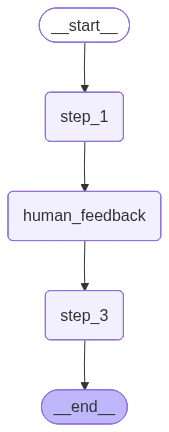

In [86]:
from IPython.display import Image,display
display(Image(graph.get_graph().draw_mermaid_png()))

In [87]:
# Input
initial_input = {"input": "hello world"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

---Step 1---
{'step_1': None}


---human_feedback---
{'__interrupt__': (Interrupt(value='Please provide feedback:', id='bc2aa2f9706311a5caefc4f0279decec'),)}




To resume from an interrupt, we can use [the `Command` object](https://langchain-ai.github.io/langgraph/how-tos/command/). 

We'll use it to resume the graph from the interrupted state, passing the value to return from the interrupt call to `resume`. 

In [88]:
# Continue the graph execution
for event in graph.stream(
    Command(resume="go to step 3!"),
    thread,
    stream_mode="updates",
):
    print(event)
    print("\n")

---human_feedback---
{'human_feedback': {'user_feedback': 'go to step 3!'}}


---Step 3---
{'step_3': None}




### Tracing

When we are using LangChain or LangGraph, LangSmith logging [will work out of the box](https://docs.smith.langchain.com/observability/how_to_guides/trace_with_langgraph) with the following environment variables set:

```
export LANGSMITH_TRACING=true
export LANGSMITH_API_KEY="<your-langsmith-api-key>"
```

Here is the LangSmith trace from above agent execution:

https://smith.langchain.com/public/6f77014f-d054-44ed-aa2c-8b06ceab689f/r

We can see that the agent is able to continue the conversation from the previous state because we used a checkpointer.

### Deployment

We can also deploy our graph using [LangGraph Platform](https://langchain-ai.github.io/langgraph/concepts/langgraph_platform/). 

This creates a server [with an API](https://langchain-ai.github.io/langgraph/cloud/reference/api/api_ref.html) that we can use to interact with our graph and an interactive IDE, LangGraph [Studio](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/).

We simply need to ensure our project has [a structure](https://langchain-ai.github.io/langgraph/concepts/application_structure/) like this:

```
my-app/
├── src/email_assistant # all project code lies within here
│   └── langgraph101.py # code for constructing your graph
├── .env # environment variables
├── langgraph.json  # configuration file for LangGraph
└── pyproject.toml # dependencies for your project
```

The `langgraph.json` file specifies the dependencies, graphs, environment variables, and other settings required to start a LangGraph server.

To test this, let's deploy `langgraph_101.py`. We have it in our `langgraph.json` file in this repo:

```
 "langgraph101": "./src/email_assistant/langgraph_101.py:app",
```

For LangGraph Platform, there are a range of [deployment options](https://langchain-ai.github.io/langgraph/tutorials/deployment/): 
 
* Local deployments can be started with `langgraph dev` from the root directory of the repo. Checkpoints are saved to the local filesystem.
* There are also various [self-hosted options](https://langchain-ai.github.io/langgraph/tutorials/deployment/#other-deployment-options). 
* For hosted deployments, checkpoints are saved to Postgres using a postgres [checkpointer](https://langchain-ai.github.io/langgraph/concepts/persistence/#checkpointer-libraries). 

Test: 
```
Draft a response to my boss (boss@company.ai) confirming that I want to attent Interrupt!
```

Here we can see a visualization of the graph as well as the graph state in Studio.

![langgraph_studio](img/langgraph_studio.png)

Also, you can see API docs for the local deployment here:

http://127.0.0.1:2024/docs